# Diagramación de una Chacra para Forestería Análoga

### © Equipo I+D SomosAZUCAR - Bajo licencia AGPLv3

```
Diagramador de Planos para Forestería Análoga
Copyright (C) 2015 Sebastian Silva

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [31]:
# Bibliotecas utilizadas para confeccionar el mapa
%matplotlib inline
import matplotlib.pyplot as plt
from shapely import geometry
import numpy as np
import pandas as pd
import random
import mpld3
from tqdm import tqdm

## 1.- DATOS INICIALES
### © Arbio - licencia por definir

La base de datos consiste en una lista de especies, cantidades, diámetro, y características.

In [71]:
especies = pd.read_csv("db.txt") ## Es una base
#especies = especies[(especies.estrato==3)]
especies.

,nombre,area,altura_piso,enredadera,productividad,estrato,N,P,K,Ca,...,10,11,12,sombra,pruductiva_en,recambio,distancia,diametro,altura,cantidad
0,Aguaje,28.27,2,0,21.22,4,0,0,0,0,...,1,1,2,0.00,90,45.00,18.00,6.00,25.00,7
1,Anona,28.27,2,0,1.70,3,0,0,0,0,...,1,1,1,0.00,60,20.00,4.50,6.00,8.00,16
2,Arazá,12.57,2,0,2.74,3,0,0,0,0,...,2,1,1,0.50,18,15.00,7.00,4.00,9.00,16
3,Camu camu,7.07,0,0,58.36,3,0,0,0,0,...,0,1,1,0.00,36,15.00,5.00,3.00,6.00,16
4,Carambola,19.64,2,0,8.96,3,0,0,0,0,...,1,2,1,0.00,42,20.00,7.00,5.00,10.00,16
5,Chacruna,3.14,2,0,25.46,2,0,0,0,0,...,1,1,1,0.50,24,NaN,1.00,2.00,2.50,62
6,Cocona,3.14,2,0,4.14,2,0,0,0,0,...,1,1,1,0.40,6,1.00,3.00,2.00,2.00,62
7,Copaiba,113.10,2,0,9.55,5,0,0,0,0,...,2,2,2,0.50,96,30.00,8.00,12.00,27.50,6
8,Copoazú,38.48,2,0,2.99,3,0,0,0,0,...,1,1,1,0.50,42,10.00,6.50,7.00,6.00,16
9,Frijol palo,1.43,2,0,11.88,2,1,0,0,0,...,0,2,2,0.40,24,10.00,1.25,1.35,2.75,62


In [72]:
consolidado = pd.DataFrame({'especies':especies.groupby('estrato').size(), 
                            'individuos':especies.groupby('estrato')['cantidad'].sum()})
pd.concat([consolidado,pd.DataFrame(consolidado.sum(axis=0),columns=['Total']).T])


,especies,individuos
estrato,,
1,2,1472
2,5,310
3,10,160
4,7,48
5,1,6
Total,25,1996


## 2.- LINDEROS DE LA CHACRA

Los linderos están definidos como un polígono en metros, desde una de las esquinas.

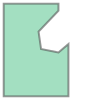

In [73]:
chacra = geometry.Polygon([ [0,0],
                            [0, 93],
                            [55, 93],
                            [55, 86],
                            [35, 65],
                            [37.5, 47.5],
                            [55, 44],
                            [65, 52.5],
                            [65, 0] ])
chacra

In [74]:
lindero_x, lindero_y = chacra.exterior.xy

## 3.- Definir ubicaciones

In [75]:
def punto_aleatorio(poligono):
    (minx, miny, maxx, maxy) = poligono.bounds
    while True:
        p = geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poligono.contains(p):
            return(p)

In [76]:
class Poblacion:
    def __init__(self, poligono, especies):
        self.poligono = poligono
        individuos_columns = ['id', 'pos', 'x', 'y', 'color', 'diametro']
        self.individuos = pd.DataFrame(index=range(especies.cantidad.sum(axis=0)), 
                                       columns=individuos_columns, )
        for especie in tqdm(especies.itertuples()):
            n_especie = especie[0]
            color_especie = np.random.rand(3,)
            planta_tipo = especies.loc[n_especie]
            total = len(self.individuos)
            for n_individuo in range(especies.cantidad[n_especie]):
                planta = planta_tipo.copy()
                planta['id'] = n_especie
                planta = self.ubicar(planta)
                if planta['pos']:
                    planta['color'] = color_especie
                    planta['diametro'] = int(float(planta['diametro'])*10)
                self.individuos.loc[n_individuo + total] = planta
                self.individuos = self.individuos.dropna()
    
    def regla_1(self, planta):
            # Regla 1: La distancia al lindero debe ser mayor que la mitad de la altura
            if planta.pos.distance(self.poligono.exterior) < planta.altura/2:
                raise ValueError('regla1')
                
    def regla_2(self, planta):
            for anterior in self.individuos.itertuples():
                if anterior[1] == planta.id:
                    if planta.pos.distance(anterior[2]) < planta.distancia:
                        raise ValueError('regla2')
                        
    def ubicar(self, planta):
        intentos = 100
        while intentos:
            intentos = intentos - 1
            distancia_min = 1 # 1m
                
            pos = punto_aleatorio(self.poligono)       
            planta['pos'] = pos
            planta['x'], planta['y'] = pos.xy
            
            try:
                self.regla_1(planta)
                self.regla_2(planta)
            except ValueError as e:
                #if e:
                #    print (e),
                next
            else:
                return planta
            
        print ("No se pudo ubicar una "+especies.loc[planta.id].nombre)
        planta['pos'] = self.poligono.representative_point()
        planta['x'], planta['y'] = planta['pos'].xy
        return planta

In [77]:
# Demora bastante
pob = Poblacion(chacra, especies)

0it [00:00, ?it/s]

No se pudo ubicar una Aguaje
No se pudo ubicar una Aguaje
No se pudo ubicar una Aguaje

In [78]:
print (especies.cantidad.sum(axis=0), len(pob.individuos))

1996 1996


## 4.- Graficar el mapa

Empezamos por los linderos de la chacra.

In [79]:
pob.individuos.dropna()

,id,pos,x,y,color,diametro
1996,0,POINT (43.34985641944779 20.490421726532),[43.34985641944779],[20.490421726532002],"[0.909730421992, 0.864163755891, 0.13249880967]",60
1997,0,POINT (19.95014279408245 52.62005273169379),[19.95014279408245],[52.62005273169379],"[0.909730421992, 0.864163755891, 0.13249880967]",60
1998,0,POINT (23.42302529724503 75.40472818102813),[23.42302529724503],[75.40472818102813],"[0.909730421992, 0.864163755891, 0.13249880967]",60
1999,0,POINT (25.6574766797307 25.202100721383),[25.657476679730696],[25.202100721383005],"[0.909730421992, 0.864163755891, 0.13249880967]",60
2000,0,POINT (23.125 45.75),[23.125],[45.75],"[0.909730421992, 0.864163755891, 0.13249880967]",60
2001,0,POINT (23.125 45.75),[23.125],[45.75],"[0.909730421992, 0.864163755891, 0.13249880967]",60
2002,0,POINT (23.125 45.75),[23.125],[45.75],"[0.909730421992, 0.864163755891, 0.13249880967]",60
7,1,POINT (36.11815822047173 74.91082772152699),[36.118158220471734],[74.91082772152699],"[0.37850189465, 0.654445711707, 0.733273107313]",60
8,1,POINT (49.99995102327694 37.40147267376602),[49.999951023276935],[37.401472673766015],"[0.37850189465, 0.654445711707, 0.733273107313]",60
9,1,POINT (29.20966376885603 60.13209723785349),[29.20966376885603],[60.132097237853486],"[0.37850189465, 0.654445711707, 0.733273107313]",60


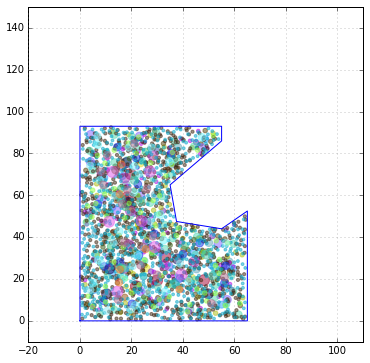

In [81]:
fig = plt.figure(figsize=(6, 6))
chacra_x, chacra_y = chacra.exterior.xy
ax = fig.add_subplot(111)
ax.set_ylim(-10,150)
ax.set_xlim(-20,110)
ax.plot( *chacra.exterior.xy )
ax.scatter(list(pob.individuos.x), 
           list(pob.individuos.y), 
           color=list(pob.individuos.color), 
           s=list(pob.individuos.diametro), 
           alpha=0.5)
ax.grid(color='gray', alpha=0.9)

In [82]:
# Gráfico interactivo
mpld3.display(fig)